In [15]:
import sys

sys.path.append("../")


from rdkit import Chem
from rdkit.Chem import Draw
from sqlmodel import create_engine, Session, select
from chemicalite_orm.models import (
    Compound,
    mol_morgan_bfp,
    mol_from_smiles,
    mol_from_smarts,
)
from chemicalite_orm.molecules import SMILES_SAMPLE as mols
from sqlalchemy import event

In [16]:
DATABASE_URL = "sqlite:///chemicalite.db?enable_load_extension=1"

engine = create_engine(DATABASE_URL, echo=False)


@event.listens_for(engine, "connect")
def load_chemicalite(dbapi_conn, connection_record):
    dbapi_conn.enable_load_extension(True)
    dbapi_conn.load_extension("chemicalite")


Compound.__table__.create(engine)

In [17]:
def insert_test_data():
    with Session(engine) as session:
        for i, smiles in enumerate(mols):
            compound = Compound(
                name=f"mol_{i}",
                smiles=smiles,
                molecule=smiles,
                mfp2=mol_morgan_bfp(mol_from_smiles(smiles), 2, 1024),
            )
            session.add(compound)
        session.commit()


insert_test_data()

In [ ]:
def test_substructure(smarts="c1ccccc1"):
    smis = []

    query_mol = mol_from_smiles(smarts)
    with Session(engine) as session:
        results = session.exec(
            select(Compound).where(Compound.molecule.hassubstruct(query_mol))
        ).all()

        for r in results:
            smis.append(r.smiles)
    return smis

smis = test_substructure()

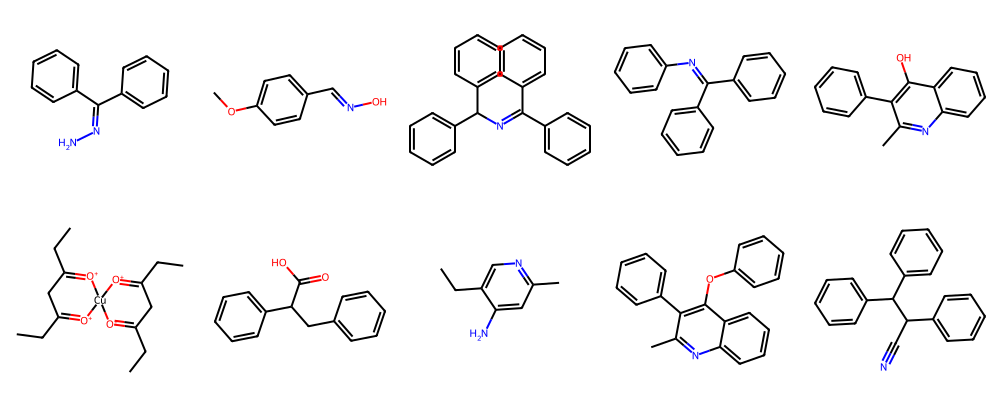

In [14]:
res_mols = [Chem.MolFromSmiles(smi) for smi in smis[:10]]
Draw.MolsToGridImage(res_mols, molsPerRow=5)